## Hereditary Geometry Discovery

- Simultaneously learn:
    - 1. Tensor that aligns Kernels (the left-action).
    - 2. Learn generator W that contains log of left-actions.
- Not implemented yet:
    - 1. Charts
    - 2. Symmetry Penalizer

In [148]:
import pickle
import os

from src.utils import load_replay_buffer
from src.learning.symmetry_discovery.differential.kernel_approx import KernelFrameEstimator

FOLDER_NAME: str="data/local/experiment/circle_rotation"
TASK_NAMES=["sac_circle_rotation_task_0", "sac_circle_rotation_task_1", "sac_circle_rotation_task_2", "sac_circle_rotation_task_3"]

LOAD_WHAT:str="next_observations"
KERNEL_DIM=1
N_SAMPLES=50_000


def load_replay_buffer_and_kernel(task_name:str, load_what:str, kernel_dim: int, n_samples:int, folder_name):
    """Loads samples and kernel evaluator of a task."""

    assert load_what in ["observations", "actions", "next_observations"], "Learn hereditary geometry for states, actions or next states."

    buffer_name= os.path.join(folder_name, f"{task_name}_replay_buffer.pkl")
    kernel_name= os.path.join(folder_name, f"{task_name}_kernel_bases.pkl")


    buffer= load_replay_buffer(buffer_name, N_steps=n_samples)
    ps=buffer[load_what]
    print(f"Loaded {load_what} from {buffer_name} with shape {ps.shape}")

    # Load kernel bases
    frameestimator=KernelFrameEstimator(ps=ps, kernel_dim=kernel_dim)
    with open(kernel_name, 'rb') as f:
        kernel_samples = pickle.load(f)
    frameestimator.set_frame(frame=kernel_samples)

    return ps, frameestimator

tasks_ps, tasks_frameestimators=[], []
for task_name in TASK_NAMES:
    ps, frameestimator = load_replay_buffer_and_kernel(task_name, LOAD_WHAT, KERNEL_DIM, N_SAMPLES, FOLDER_NAME)
    tasks_ps.append(ps)
    tasks_frameestimators.append(frameestimator)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_0_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_1_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_2_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_3_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


In [149]:
import torch
SEED=40
train_goal_locations=[
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
 {'goal': torch.tensor([ 0.95243384, -0.30474544])},
 {'goal': torch.tensor([-0.11289421, -0.99360701])},
 {'goal': torch.tensor([-0.81394263, -0.58094525])}]

In [152]:
%load_ext autoreload
%autoreload 2
from src.learning.symmetry_discovery.differential.hereditary_geometry_discovery import HereditaryGeometryDiscovery


her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,tasks_frameestimators=tasks_frameestimators, kernel_dim=KERNEL_DIM, batch_size=128, seed=SEED, bandwidth=0.5,
                                        task_specifications=train_goal_locations,
                                        lg_inits_how="mode")
her_geo_dis.optimize(n_steps=5_000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loss: 5.28e-05, Task Losses: [0. 0. 0.]: 100%|██████████| 5000/5000 [00:08<00:00, 621.06it/s]         


In [83]:
#Oracle rotation matrices
import torch

def rotation_matrix_2d(v, u):
    v = v / torch.norm(v)
    u = u / torch.norm(u)
    c = torch.dot(u, v)
    s = u[0] * v[1] - u[1] * v[0]  # 2D scalar cross product
    R = torch.tensor([[c, -s],
                      [s,  c]])
    return R


v1 = train_goal_locations[0]['goal']
v2 = train_goal_locations[1]['goal']
v3 = train_goal_locations[2]['goal']
v4 = train_goal_locations[3]['goal']

R_11 = rotation_matrix_2d(v1, v1)  # Rotates v2 to v1 direction
R_21 = rotation_matrix_2d(v2, v1)  # Rotates v2 to v1 direction
R_31 = rotation_matrix_2d(v3, v1)  # Rotates v3 to v1 direction
R_41 = rotation_matrix_2d(v4, v1)  # Rotates v3 to v1 direction
ground_truth_rotations=[R_11, R_21, R_31, R_41]

In [153]:
her_geo_dis.evalute_left_actions(lgs=torch.tensor(torch.stack(ground_truth_rotations[1:])), track_loss=False)
print("Loss of each task using ground-truth left-action (should be low)", her_geo_dis.task_losses)

Loss of each task using ground-truth left-action (should be low) tensor([8.6981e-08, 5.7086e-08, 6.8271e-08])


/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_28298/3681899776.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  her_geo_dis.evalute_left_actions(lgs=torch.tensor(torch.stack(ground_truth_rotations[1:])), track_loss=False)
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.stack([torch.tensor(self.task_specifications[i]['goal']) for i in self.task_idxs])


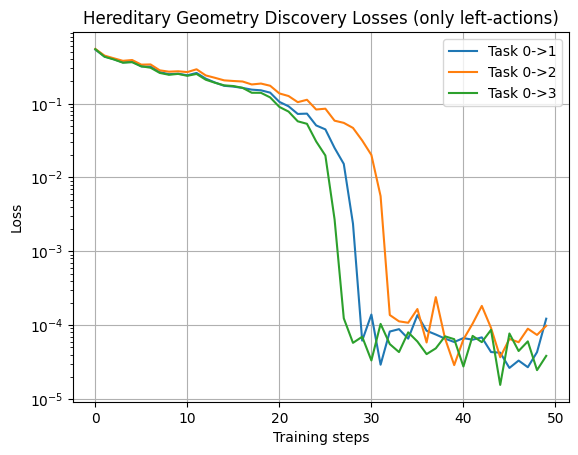

In [151]:
import matplotlib.pyplot as plt
import numpy as np

for idx_task in range(len(tasks_ps)-1):
    plt.plot(np.array(her_geo_dis._losses)[::100, idx_task], label=f"Task 0->{idx_task+1}")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Hereditary Geometry Discovery Losses (only left-actions)")
plt.show()

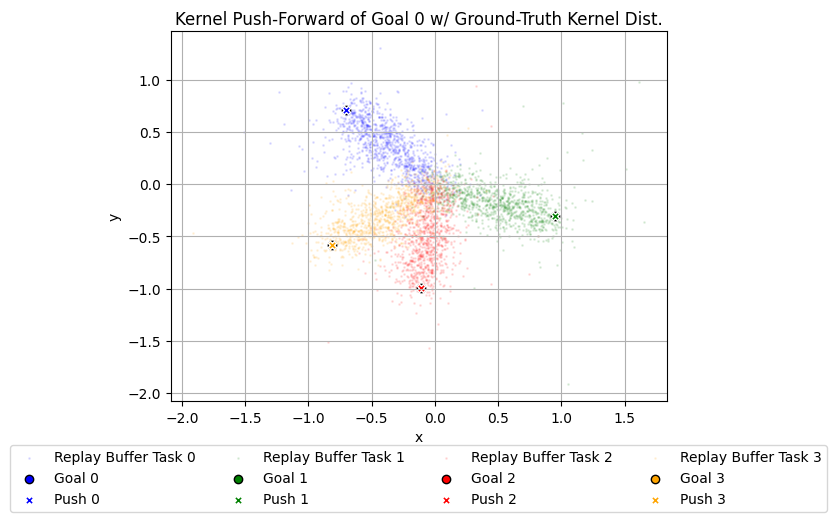

In [154]:
goal_0_pushed=torch.einsum("Nmn,m->Nn", her_geo_dis.lgs, train_goal_locations[0]["goal"]).detach().numpy()  # shape (n_tasks-1, b, n)

PLOT_EVERY=100
colors= ['blue', 'green', 'red', 'orange']
for idx in range(len(tasks_ps)):
    plt.scatter(tasks_ps[idx][::PLOT_EVERY, 0], tasks_ps[idx][::PLOT_EVERY, 1], label=f'Replay Buffer Task {idx}', s=1, alpha=0.1, c=colors[idx])
    goal_location=train_goal_locations[idx]["goal"]
    
    push_goal_base=ground_truth_rotations[idx]@train_goal_locations[0]["goal"]
    plt.scatter(goal_location[0], goal_location[1], color=colors[idx], edgecolor='black', label=f'Goal {idx}')
    plt.scatter(push_goal_base[0], push_goal_base[1], color=colors[idx], edgecolor='white', label=f'Push {idx}', marker="X")

# plt.xlim(-1.5, 1.5)
# plt.ylim(-1.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.title('Kernel Push-Forward of Goal 0 w/ Ground-Truth Kernel Dist.')
plt.grid()
plt.show()

## Matrix Logarithm

In [154]:
import scipy.linalg
import torch

def adjoint(A, E, f):
    A_H = A.mH.to(E.dtype)
    n = A.size(0)
    M = torch.zeros(2*n, 2*n, dtype=E.dtype, device=E.device)
    M[:n, :n] = A_H
    M[n:, n:] = A_H
    M[:n, n:] = E
    return f(M)[:n, n:].to(A.dtype)

def logm_scipy(A):
    return torch.from_numpy(scipy.linalg.logm(A.cpu(), disp=False)[0]).to(A.device)

class Logm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A):
        assert A.ndim == 2 and A.size(0) == A.size(1)  # Square matrix
        assert A.dtype in (torch.float32, torch.float64, torch.complex64, torch.complex128)
        ctx.save_for_backward(A)
        return logm_scipy(A)

    @staticmethod
    def backward(ctx, G):
        A, = ctx.saved_tensors
        return adjoint(A, G, logm_scipy)

logm = Logm.apply

A = torch.rand(3, 3, dtype=torch.float64, requires_grad=True)
torch.autograd.gradcheck(logm, A)

True

Compute oracle loss

In [ ]:
oracle_lgs=torch.stack([R_21, R_31],dim=0)
oracle_lgs.shape

her_geo_dis.evalute_left_actions(lgs=oracle_lgs, track_loss=False)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:151: UserWarning: Using hard-coded kernel. Only use for debugging.
  warnings.warn("Using hard-coded kernel. Only use for debugging.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.stack([torch.tensor(self.task_specifications[i]['goal']) for i in self.task_idxs])


tensor(8.2061)